In [1]:
from functions import *

In [2]:
cur_file = FILE_SENSORS_DATA_EST_PARAMS
df = pd.read_csv(cur_file)

In [3]:
x_format = None
TIME_MINS = 0
DATE_TIME = 1
TIME_IDX  = TIME_MINS

In [4]:
FLUX_COL = 'flux at 20° [L/m^2h]' #'flux [L/m^2h]'
FLUX_USED = FLUX_COL[:-9]
print(FLUX_USED)

flux at 20°


In [5]:
# exclude clear water case with no fouling
#df = df[(df['initial feed concentration [g/L]'] > 0)]
# exclude too far arima simulation (apart from estimated initial flux)
MAX_TIME = 32
df = df[(df['time [m]'] <= MAX_TIME)]
for c in df.columns :
    if c not in ['file_idx', 'tmp_idx', 'date', 'time [m]', 'index', 'initial feed concentration [g/L]'] :
        df[c] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x[c], axis=1)
# df = df[(df['is flux steady'] == 0.0) | (df['is flux steady'].isna())]
df['is forecast'] = df['is forecast'].astype(float)

In [6]:
# remove clear water samples
#df = df[df['initial feed concentration [g/L]'] > 0]
# save df for final VALIDATION
#df_dirty_water = df.reset_index(drop=True)
#df_dirty_water['index'] = range(0, len(df))
# remove low TMP samples from TRAINING
#tmp = df['TMP est [kPa]'].shift(1) # shift is used to remove also the final NaN rows of the unwanted groups
#df = df[(df['TMP est [kPa]'] > 200) | (pd.isna(df['TMP est [kPa]']) & (tmp > 200)) ]
# reset indexes
df['index'] = range(0, len(df))
df = df.reset_index(drop=True)
conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df, time_col='index')

   0: feed conc = 0.00 [g/L]
 256: feed conc = 0.49 [g/L]
 448: feed conc = 1.30 [g/L]
 512: feed conc = 1.71 [g/L]


In [7]:
coeff_prs_permeate =    read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'prs permeate [kPa]') 
PRS_PERMEATE_EST = coeff_prs_permeate['intercept'] # constant value 
INITIAL_VISCOSITY = calc_viscosity(20, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water')
df = add_initial_flux(df, INITIAL_VISCOSITY)

In [8]:
# get the index of the first row of each setting
group_cols = ['file_idx', 'tmp_idx']
init_cond = list(df[group_cols].drop_duplicates().index)
df.loc[init_cond][['index', 'file_idx', 'tmp_idx', 'date', 'initial feed concentration [g/L]', 'TMP est [kPa]', 'flux at 20° [L/m^2h]', 'is forecast',]]

,index,file_idx,tmp_idx,date,initial feed concentration [g/L],TMP est [kPa],flux at 20° [L/m^2h],is forecast
0,0,0,0,2023-11-08,0.000000,402.599676,569.878476,0.0
32,32,0,1,2023-11-08,0.000000,383.741771,507.767038,0.0
65,65,0,2,2023-11-08,0.000000,346.387036,439.859170,0.0
98,98,0,3,2023-11-08,0.000000,289.723263,367.642354,0.0
131,131,0,4,2023-11-08,0.000000,250.248126,312.720932,0.0
164,164,0,5,2023-11-08,0.000000,180.095084,223.358522,0.0
197,197,0,6,2023-11-08,0.000000,145.356988,177.238124,0.0
230,230,1,0,2023-11-09,0.000000,148.334502,178.022743,0.0
263,263,2,0,2023-11-09,0.485017,149.056304,182.229016,0.0
296,296,2,2,2023-11-09,0.485017,188.666900,157.932526,0.0


In [9]:
n=2
k_n = f'k(n={n})'
flux_pred_lbl = f'flux pred {k_n}'
df[flux_pred_lbl] = np.nan
#cur_k_n_pred = cur_k_n_pred.reset_index(drop=True)
#j = np.nan
new_series = True
for i in range(len(df)) :
    cur_time = df.loc[i, 'time [m]'].astype(int)
    flux_min = df.loc[i, f'{FLUX_USED} min [L/m^2h]']
    if new_series :
        df.loc[i, flux_pred_lbl] = df.loc[i, FLUX_COL]
        new_series = False
    else :
        #print(i, cur_time, df.loc[i, 'file_idx'], df.loc[i, 'tmp_idx'])
        bef_flux = df.loc[i-1, flux_pred_lbl]
        k = df.loc[i, k_n] #k = k_n_pred[j]
        k = 0 if pd.isna(k) else k
        k = 0 if pd.notna(k) and k < 0 else k
        if n == 2 :
            cur_flux = (bef_flux + k * flux_min) / (1+k)
        else :
            cur_flux = np.nan
        df.loc[i, flux_pred_lbl] = cur_flux
        #j += 1
        bef_k = k / 1.5
        
    if pd.isna(flux_min) :
        new_series = True
            

   0: feed conc = 0.00 [g/L]
 263: feed conc = 0.49 [g/L]
 461: feed conc = 1.30 [g/L]
 527: feed conc = 1.71 [g/L]


Text(0.5, 0, 'time [m]')

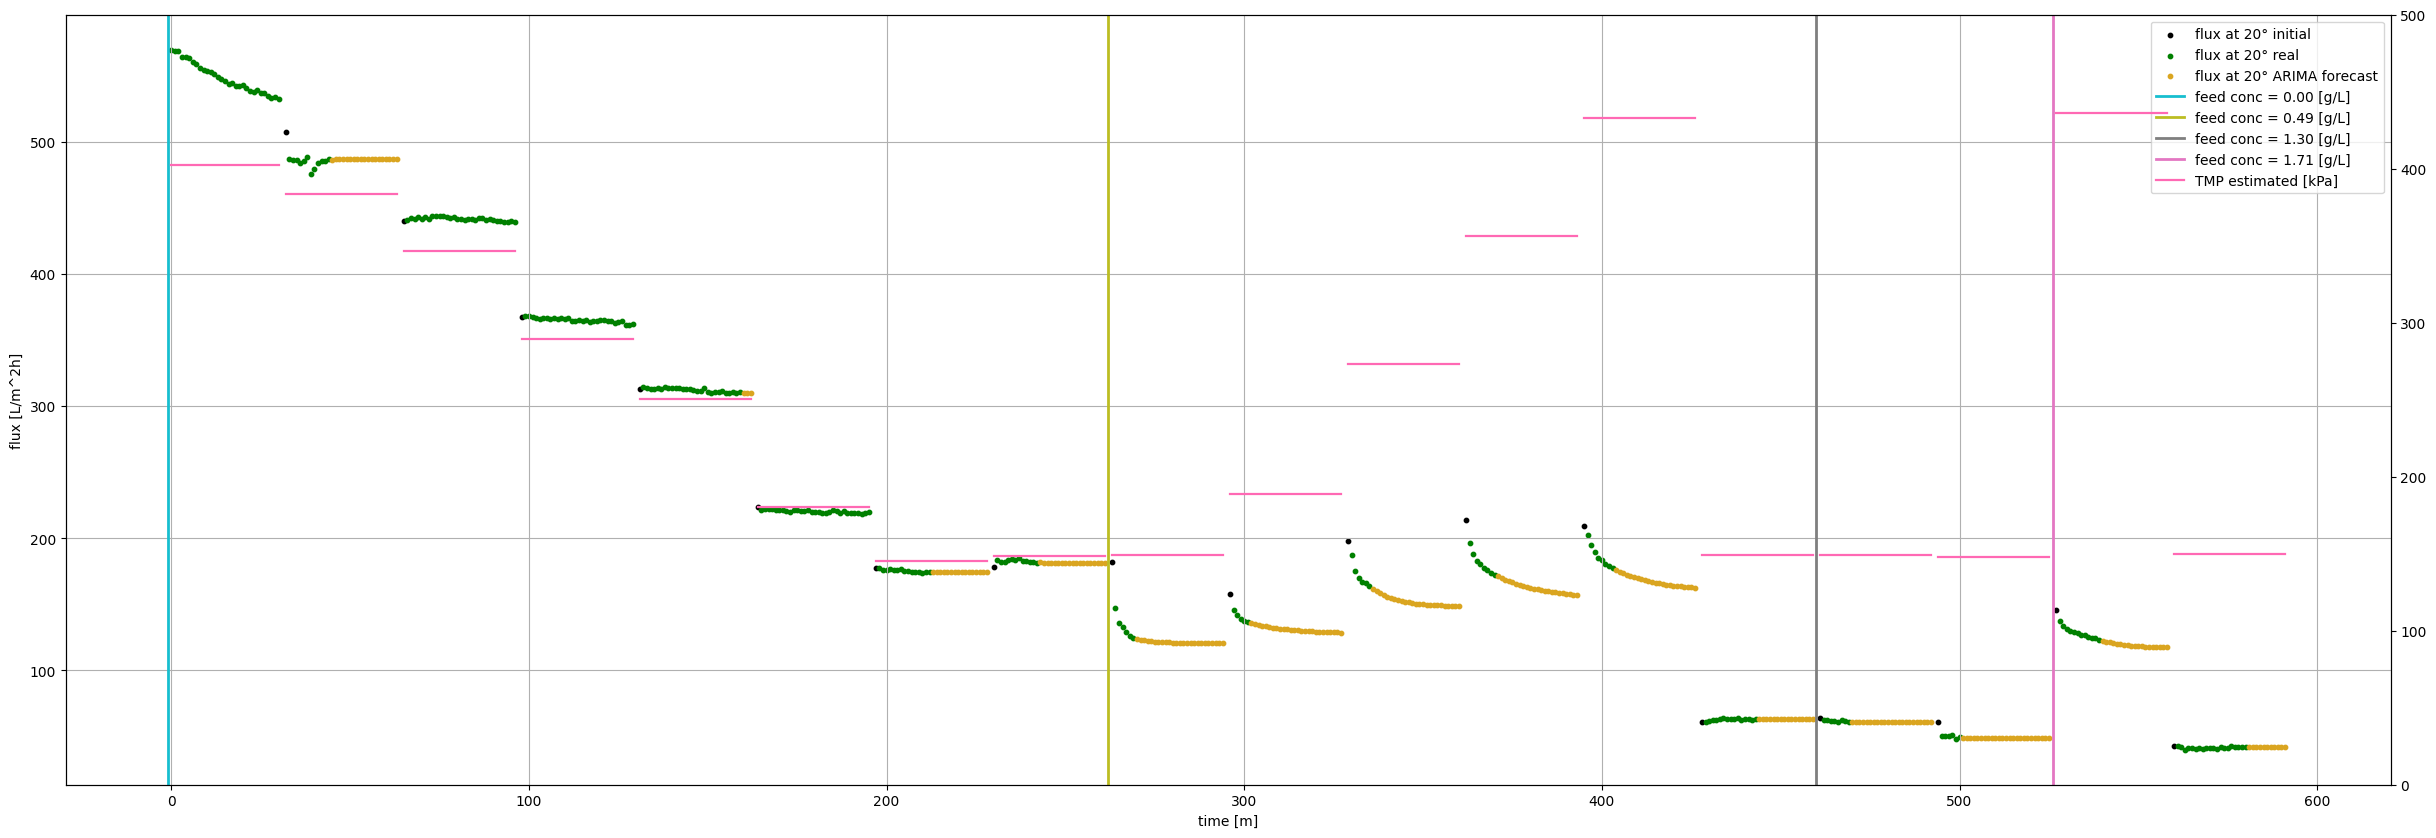

In [10]:
df_frcst   = df[df['is forecast'] == 1]
df_real    = df[(df['is forecast'] == 0) & (df['is initial'] == 0)]
df_initial = df[df['is initial']  == 1]

flux = FLUX_COL
# plot_time_series_1_axis(x=df_real['index'],  y_series={'flux real'    : df_real[flux]},            x_ax_lbl=df_real['index'],  y_ax_lbl=None,            title=None,                           color=['green'])
# plot_time_series_1_axis(x=df_frcst['index'], y_series={'flux forecast': df_frcst[flux]},           x_ax_lbl=df_frcst['index'], y_ax_lbl=None,            title=None,                           color=['gold'],  figsize=None)
# plot_time_series_1_axis(x=df['index'],       y_series={'flux pred using k(n=2)': df['flux pred']}, x_ax_lbl=df['index'],       y_ax_lbl='flux [L/m^2h]', title='Flux estimation given k(n=2)', color=['red'], figsize=None)

fig, ax1 = plot.subplots(figsize=(30,10))
ax2 = ax1.twinx()
#ax1.plot(   df['index'],       df[flux],                       color='black', marker='o', markersize=0, linestyle='--')
#ax1.plot(   df['index'],       df['flux pred k(n=2)'],         color='orangered',   marker='o', markersize=0, linestyle='--')
ax1.scatter(df_initial['index'],  df_initial[flux],      color='black', marker='o', s=10, label=f'{FLUX_USED} initial')
ax1.scatter(df_real['index'],     df_real[flux],         color='green', marker='o', s=10, label=f'{FLUX_USED} real')
ax1.scatter(df_frcst['index'],    df_frcst[flux],        color='goldenrod',  marker='o', s=10, label=f'{FLUX_USED} ARIMA forecast')
#ax1.scatter(df['index'],       df['flux pred k(n=2)'],          color='orangered',   marker='o', s=10, label=f'{FLUX_USED} using estimated k(n=2)')
ax2.plot(   df['index'],       df['TMP est [kPa]'],            color='hotpink',   marker='o', markersize=0, lw=1.6, label='TMP estimated [kPa]')

conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df, time_col='index')
i = len(COLOR_CYCLE) - 1
for (line_x,lbl) in conc_lines.items() :
    ax1.axvline(x=line_x-1, label=lbl, color=COLOR_CYCLE[i], linewidth=2)
    i -= 1

ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')
ax2.set_ylim((0,500))
ax1.set_ylabel('flux [L/m^2h]')
ax1.set_xlabel('time [m]')
#ax2.set_ylabel('pressure [kPa]')
#plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_2.png')

In [11]:
y_col = FLUX_COL
y = df[FLUX_COL].dropna()
y_pred = df['flux pred k(n=2)'].dropna()
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)

        flux at 20° [L/m^2h]  absolute error  relative error  squared error
min                39.858642        0.000000        0.000000       0.000000
median            168.785072        0.919872        0.004468       0.846164
mean              212.104006        2.238034        0.020299      17.960326
max               569.878476       29.908578        0.235936     894.523024
var             22476.367806       12.974095        0.002356    4267.448749
std               149.921205        3.601957        0.048539      65.325713

Error metrics:
R^2      0.9992
RMSE     4.2380
MAE      2.2380
MedAE    0.9199
maxAE   29.9086
MAPE     0.0203
maxAPE   0.2359


{'R^2': 0.9991995318670526,
 'RMSE': 4.237962530010831,
 'MAE': 2.238033646504229,
 'MedAE': 0.9198718077167527,
 'maxAE': 29.90857777240521,
 'MAPE': 0.020298526467530217,
 'maxAPE': 0.23593612983531304}